# IS319 - Deep Learning

## TP2 - Dogs vs. cats (TensorFlow/Keras)

Credits: Baptiste Pesquet

![Woof Meow](woof_meow.jpg)

In this TP, the goal is to train neural networks to classify images of dogs and cats, using the TensorFlow/Keras library.

The images used in this TP are extracted from the [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/) dataset available on Kaggle, which contains 25000 images. First, we use a subset of 2000 images to decrease training time, for educational purposes. Later on, you can experiment with the full dataset using a GPU.

Most questions are open-ended: feel free to experiment with different settings. **Remember to analyze and explain what you are doing in additional cells.**

## Author : Jad El Karchi

## Environment setup

In [2]:
!pip install numpy
!pip install matplotlib
!pip install tensorflow[and-cuda]
import os
import random
import zipfile
import numpy as np
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.5/728.5 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.3/210.3 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.5/549.5 MB 2.9 MB/s eta 0:00:00


In [3]:

import tensorflow as tf

# initalizing seed
tf.random.set_seed(123)
np.random.seed(123)
random.seed(123)

# version
print(tf.reduce_sum(tf.random.normal([10000, 10000])))
print(f'TensorFlow version: {tf.__version__}')

tf.Tensor(-19989.355, shape=(), dtype=float32)
TensorFlow version: 2.14.0


In [4]:
def plot_loss_acc(history):
    """Plot training and (optionally) validation loss and accuracy"""
    loss = history.history['loss']
    acc = history.history['accuracy']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, '.--', label='Training loss')
    final_loss = loss[-1]
    title = 'Training loss: {:.4f}'.format(final_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, 'o-', label='Validation loss')
        final_val_loss = val_loss[-1]
        title += ', Validation loss: {:.4f}'.format(final_val_loss)
    plt.title(title)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, '.--', label='Training acc')
    final_acc = acc[-1]
    title = 'Training accuracy: {:.2f}%'.format(final_acc * 100)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    if 'val_accuracy' in history.history:
        val_acc = history.history['val_accuracy']
        plt.plot(epochs, val_acc, 'o-', label='Validation acc')
        final_val_acc = val_acc[-1]
        title += ', Validation accuracy: {:.2f}%'.format(final_val_acc * 100)
    plt.title(title)
    plt.legend()

    plt.tight_layout()

## 1. Load and explore the dataset

In [5]:
# Downloading our example data, a .zip of 2000 JPG pictures, and extracting it locally in `/tmp`
!wget --no-check-certificate --no-clobber \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

# Extracting zip file to the base directory `/tmp/cats_and_dogs_filtered`
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')

# Directories with training/validation cat/dogs pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')

# Display the sizes of our dataset
print(f'Number of train cat images: {len(os.listdir(train_cats_dir))}')
print(f'Number of train dog images: {len(os.listdir(train_dogs_dir))}')
print(f'Number of valid cat images: {len(os.listdir(valid_cats_dir))}')
print(f'Number of valid dog images: {len(os.listdir(valid_dogs_dir))}')

# Display some images files for cats and dogs
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)
valid_cat_fnames = os.listdir(valid_cats_dir)
valid_dog_fnames = os.listdir(valid_dogs_dir)
print(train_dog_fnames[:10])
print(train_cat_fnames[:10])
print(valid_dog_fnames[:10])
print(valid_cat_fnames[:10])

--2023-11-12 18:58:44--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.251.2.207, 2607:f8b0:4023:c06::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   139MB/s    in 0.5s    

2023-11-12 18:58:45 (139 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Number of train cat images: 1000
Number of train dog images: 1000
Number of valid cat images: 500
Number of valid dog images: 500
['dog.981.jpg', 'dog.447.jpg', 'dog.280.jpg', 'dog.336.jpg', 'dog.928.jpg', 'dog.43.jpg', 'dog.213.jpg', 'dog.466.jpg', 'dog.739.jpg', 'dog.805.jpg']
['cat.479.jpg', 'cat.274.jpg', 'cat.37.jpg', 'cat.588.jpg', 'cat.342.jpg', 'cat.755.jpg', 'cat.46

train sets 2 first rows | valid sets 2 last rows: 


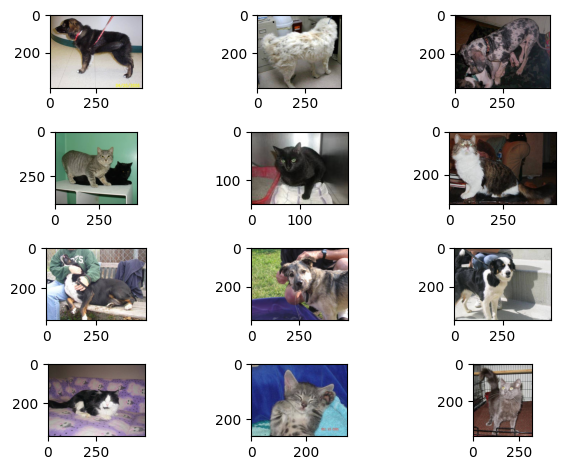

In [6]:
# Displaying training/testing sample images of dataset of woofs/meows
import matplotlib.image as mpimg

n = 3
train_dog_imgs = [mpimg.imread(os.path.join(train_dogs_dir, fname)) for fname in train_dog_fnames[:n]]
train_cat_imgs = [mpimg.imread(os.path.join(train_cats_dir, fname)) for fname in train_cat_fnames[:n]]
valid_dog_imgs = [mpimg.imread(os.path.join(valid_dogs_dir, fname)) for fname in valid_dog_fnames[:n]]
valid_cat_imgs = [mpimg.imread(os.path.join(valid_cats_dir, fname)) for fname in valid_cat_fnames[:n]]
imgs = [train_dog_imgs, train_cat_imgs, valid_dog_imgs, valid_cat_imgs]

f, axarr = plt.subplots(4,n)
print("train sets 2 first rows | valid sets 2 last rows: ")
for i in range(4) :
    for j in range(n) :
        axarr[i,j].imshow(imgs[i][j])

plt.tight_layout()
plt.show()

## 2. Prepare the dataset

**(Question)** Following the documentation, use the `tf.keras.utils.image_dataset_from_directory` function to create `train_dataset` and `valid_dataset` objects from the directory paths defined above. Make sure to have binary labels as we are doing binary classification. To start, you can use a lower image size (for example 128x128).

In [70]:
# Create training/validation dataset

def clean_df(x, y) :
    # normalize and one hot encode y
    return x / 255. , tf.one_hot(y, 2)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, labels='inferred', image_size=(128, 128), shuffle=True, seed=42).map(lambda x, y : clean_df(x, y))
valid_dataset = tf.keras.utils.image_dataset_from_directory(valid_dir, labels='inferred', image_size=(128, 128), shuffle=True, seed=42).map(lambda x, y : clean_df(x, y))

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


## 3. Training CNN models

**(Question)** Create a CNN classification model able to be trained on your dataset. Show its summary with the `model.summary()`method.
Make sure to include a layer to normalize input data (or to normalize your dataset object beforehand).

In [62]:
# importing needed tools for CNNs
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy

# Building Model
model = tf.keras.models.Sequential([
Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
MaxPooling2D(2, 2),

Conv2D(64, (3,3), activation='relu'),
MaxPooling2D(2,2),

Conv2D(64, (3,3), activation='relu'),
MaxPooling2D(4,4),

Flatten(),

Dense(32, activation='relu'),
Dense(32, activation='relu'),
Dense(2, activation='sigmoid')
])

model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_67 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_71 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_68 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_72 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_69 (MaxPooli  (None, 7, 7, 64)        

**(Question)** "Compile" and train your model with an appropriate loss function. Monitor train and validation accuracy (you can use the `plot_loss_acc` function defined above). You should be able to reach a validation accuracy >70%. Analyze your results.

In [44]:
# Compiling and fitting the dataset in the model
model.compile(optimizer='SGD', loss="BinaryCrossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
history = model.fit(train_dataset, epochs=20, validation_data=valid_dataset)

Epoch 1/20
63/63 [==============================] - 8s 82ms/step - loss: 0.6928 - accuracy: 0.5245 - recall_13: 0.1285 - val_loss: 0.6935 - val_accuracy: 0.4727 - val_recall_13: 0.2852
Epoch 2/20
63/63 [==============================] - 5s 66ms/step - loss: 0.6918 - accuracy: 0.5375 - recall_13: 0.3555 - val_loss: 0.6910 - val_accuracy: 0.5430 - val_recall_13: 0.4297
Epoch 3/20
63/63 [==============================] - 3s 43ms/step - loss: 0.6913 - accuracy: 0.5440 - recall_13: 0.5375 - val_loss: 0.6903 - val_accuracy: 0.5273 - val_recall_13: 0.5039
Epoch 4/20
63/63 [==============================] - 3s 39ms/step - loss: 0.6903 - accuracy: 0.5410 - recall_13: 0.5615 - val_loss: 0.6879 - val_accuracy: 0.5625 - val_recall_13: 0.6055
Epoch 5/20
63/63 [==============================] - 5s 78ms/step - loss: 0.6891 - accuracy: 0.5785 - recall_13: 0.5870 - val_loss: 0.6895 - val_accuracy: 0.5352 - val_recall_13: 0.5312
Epoch 6/20
63/63 [==============================] - 4s 63ms/step - loss: 0.

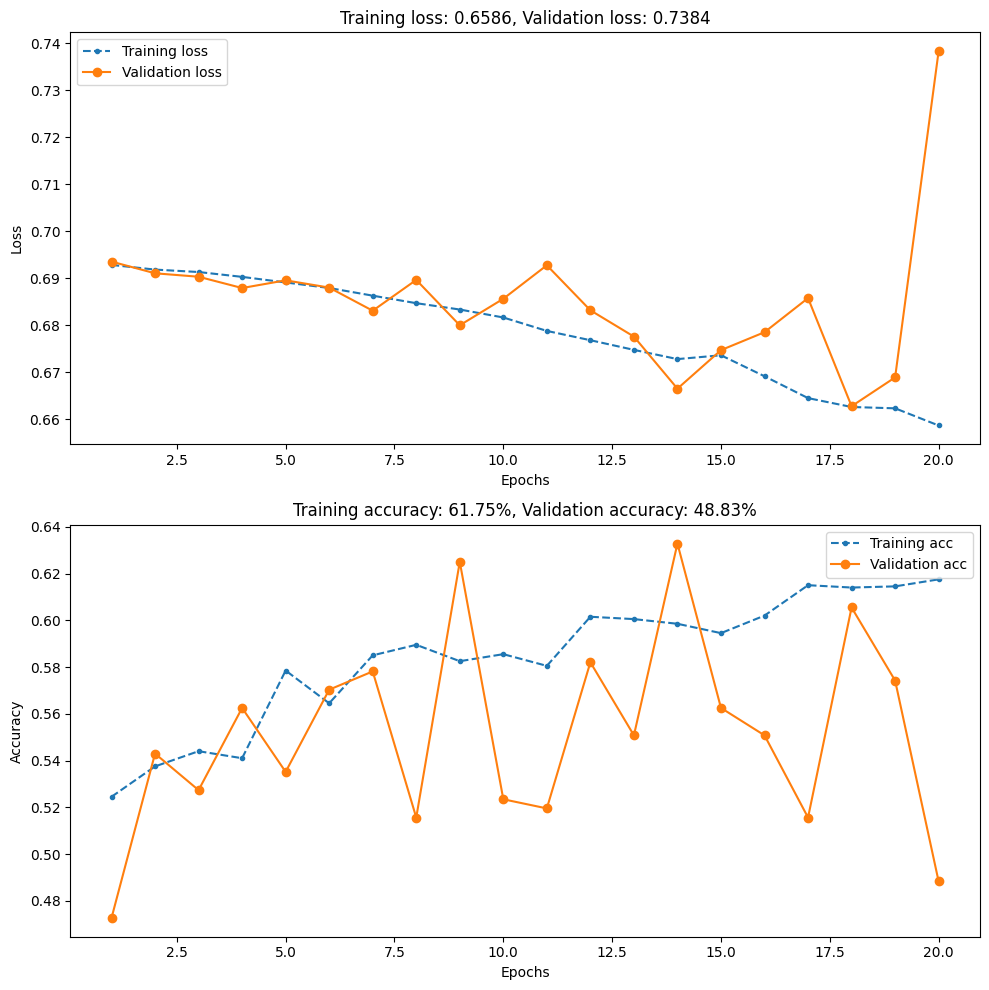

In [45]:
plot_loss_acc(history)

# We find it quite difficult to predict the behavior of our neural networks when building it. It's something we should really focus on in next lessons.
****

## Answer :
(Supposedly) for each epoch iteration the loss function of the training and validation decreases and the accuracy increases. At one point in the fitting, the model will gradually overfit and focus on it's training dataset and thus the accuracy score of the validation dataset will decrease. The training should then be stopped before the overfitting.

**(Question)** Make sure your code is using a GPU if one is available. Modify your code accordingly, if necessary. What kind of speedup do you observe?

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
gpu_to_use = None
if gpus:
    print("GPU detected:", gpus)

    # Use the first GPU if multiple GPUs are available
    gpu_to_use = gpus[0]
    with tf.device(gpu_to_use):
      model = tf.keras.models.Sequential([
      Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
      MaxPooling2D(2, 2),

      Conv2D(64, (3,3), activation='relu'),
      MaxPooling2D(2,2),

      Conv2D(64, (3,3), activation='relu'),
      MaxPooling2D(4,4),

      Flatten(),

      Dense(32, activation='relu'),
      Dense(32, activation='relu'),
      Dense(2, activation='sigmoid')
      ])

      model.compile(optimizer='SGD', loss="BinaryCrossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
      history = model.fit(train_dataset, epochs=20, validation_data=valid_dataset)


# Answer :
It's faster :)

training time and performance metrics is way faster and more fluent for our current workload going from 6 minutes on a i5-7500 to 8 seconds on T4 GPU.

## 4. Preventing overfitting

**(Question)** Experiment with various deep learning techniques to prevent overfitting.

Some suggested strategies are:

- Adding data augmentation: possible transformations are random (horizontal) flips, rotations, translations, crops, and zooms
    - (When using data augmentation, it is always good to visualize some of your transformations)
- Adding dropout to the classification part
- Adding appropriate batch normalization layers in different parts of the network

In [71]:
import cv2
import numpy as np
from skimage.transform import AffineTransform, warp
from skimage.exposure import rescale_intensity
from tensorflow.keras.preprocessing.image import apply_affine_transform
from skimage.transform import warp, AffineTransform
from PIL import Image

# Data augmentation methods
def rotate_image(image, angle=tf.random.uniform(shape=[], minval=45, maxval=90)):
    image = tf.image.rot90(image, k=tf.cast(angle, dtype=tf.int32))
    return image.numpy()

def translate_image(image, tx=random.randint(50, 100),
                    ty=random.randint(50, 100)):
    translated_image = np.roll(image, (ty, tx), axis=(0, 1))
    return translated_image

def flip_image(image, horizontal=True):
    if horizontal:
        flipped_image = np.fliplr(image)
    else:
        flipped_image = np.flipud(image)
    return flipped_image

def zoom_image(image, scale_factor=tf.random.uniform(shape=[], minval=0.5, maxval=0.8)):
    image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
    image_np = image.numpy()

    zoomed_image = warp(image_np, AffineTransform(scale=(scale_factor, scale_factor)))
    zoomed_image = tf.convert_to_tensor(zoomed_image, dtype=tf.float32)

    return zoomed_image


transformations = [rotate_image, translate_image, flip_image, zoom_image]
num_augmentations = 1

def augment_dataset(dataset):
    X_aug_list, y_aug_list = [], []
    for X, y in dataset:
        for i in range(len(X)) :
            original_image = X[i]
            label = y[i]

            X_aug_img, y_aug_img = [], []

            X_aug_img.append(original_image)
            y_aug_img.append(label)

            for _ in range(num_augmentations):
                for transformation in transformations :
                  augmented_image = transformation(X[i])
                  X_aug_img.append(augmented_image)
                  y_aug_img.append(label)

        X_aug_list.append(X_aug_img)
        y_aug_list.append(y_aug_img)

    return tf.data.Dataset.from_tensor_slices((np.array(X_aug_list), np.array(y_aug_list)))

In [47]:
augmented_dataset = augment_dataset(train_dataset)

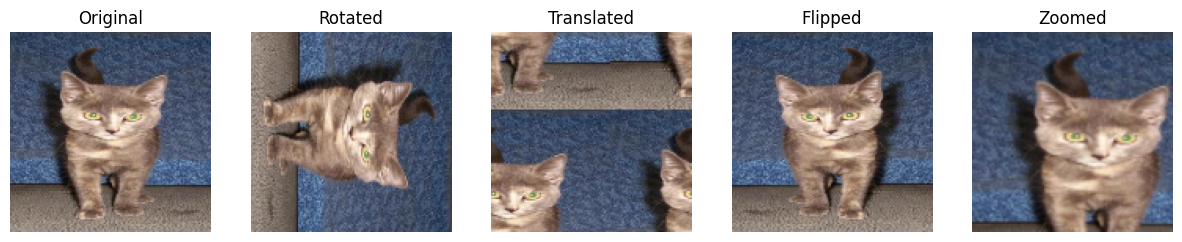

In [73]:
# Showcase the transformation applied to the original pictures
def plot_transformation(image, transformations, image_titles):
    num_transformations = len(transformations) + 1  # Including the original image
    fig, axes = plt.subplots(1, num_transformations, figsize=(15, 5))

    # Plot the original image
    axes[0].imshow(image)
    axes[0].set_title('Original')
    axes[0].axis('off')

    # Apply and plot each transformation
    for i, transform in enumerate(transformations):
        transformed_image = transform(image)
        axes[i + 1].imshow(transformed_image)
        axes[i + 1].set_title(image_titles[i])
        axes[i + 1].axis('off')

    plt.show()

image_titles = ['Rotated', 'Translated', 'Flipped', 'Zoomed']

for image, _ in train_dataset :
  plot_transformation(image[0], transformations, image_titles)
  break

In [74]:
# Optimizing our previous model
model_opt = Sequential([
# Initializing properly the weights with Glorot methods
Conv2D(32, (3,3), activation='relu', kernel_initializer=GlorotNormal ,input_shape=(128, 128, 3)),

# Batch normalization and dropouts
BatchNormalization(),
MaxPooling2D(2, 2),
Dropout (0.25),

Conv2D(64, (3,3), activation='relu', kernel_initializer=GlorotNormal),
MaxPooling2D(2,2),
Dropout(0.25),

Conv2D(64, (3,3), activation='relu', kernel_initializer=GlorotNormal),
MaxPooling2D(4,4),
Dropout(0.25),

Flatten(),

Dense(32, activation='relu', kernel_initializer=GlorotNormal),
Dropout(0.5),
Dense(32, activation='relu', kernel_initializer=GlorotNormal),
Dropout(0.5),
Dense(2, activation='sigmoid', kernel_initializer=GlorotNormal)
])

model_opt.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_76 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_3 (Bat  (None, 126, 126, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_73 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 conv2d_77 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_74 (MaxPooli  (None, 30, 30, 64)      

**(Question)** Train your model with deep learning techniques. Analyze the results and compare with the previous model.

In [75]:
# Compiling the model with adam optimizer for adaptive learning rate and binary cross entropy loss function
model_opt.compile(optimizer=Adam(learning_rate=0.001), loss="BinaryCrossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
history = model_opt.fit(augmented_dataset, epochs=20, validation_data=valid_dataset)

Epoch 1/20
63/63 [==============================] - 5s 25ms/step - loss: 0.7810 - accuracy: 0.5079 - recall_20: 0.3460 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_recall_20: 0.0000e+00
Epoch 2/20
63/63 [==============================] - 2s 28ms/step - loss: 0.6935 - accuracy: 0.4476 - recall_20: 0.0190 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_recall_20: 0.0000e+00
Epoch 3/20
63/63 [==============================] - 2s 27ms/step - loss: 0.6937 - accuracy: 0.4762 - recall_20: 0.0063 - val_loss: 0.6932 - val_accuracy: 0.5020 - val_recall_20: 0.0000e+00
Epoch 4/20
63/63 [==============================] - 1s 21ms/step - loss: 0.6934 - accuracy: 0.4794 - recall_20: 0.0381 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_recall_20: 0.0000e+00
Epoch 5/20
63/63 [==============================] - 2s 27ms/step - loss: 0.6933 - accuracy: 0.5016 - recall_20: 0.0476 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_recall_20: 0.0000e+00
Epoch 6/20
63/63 [==============================] - 2s 

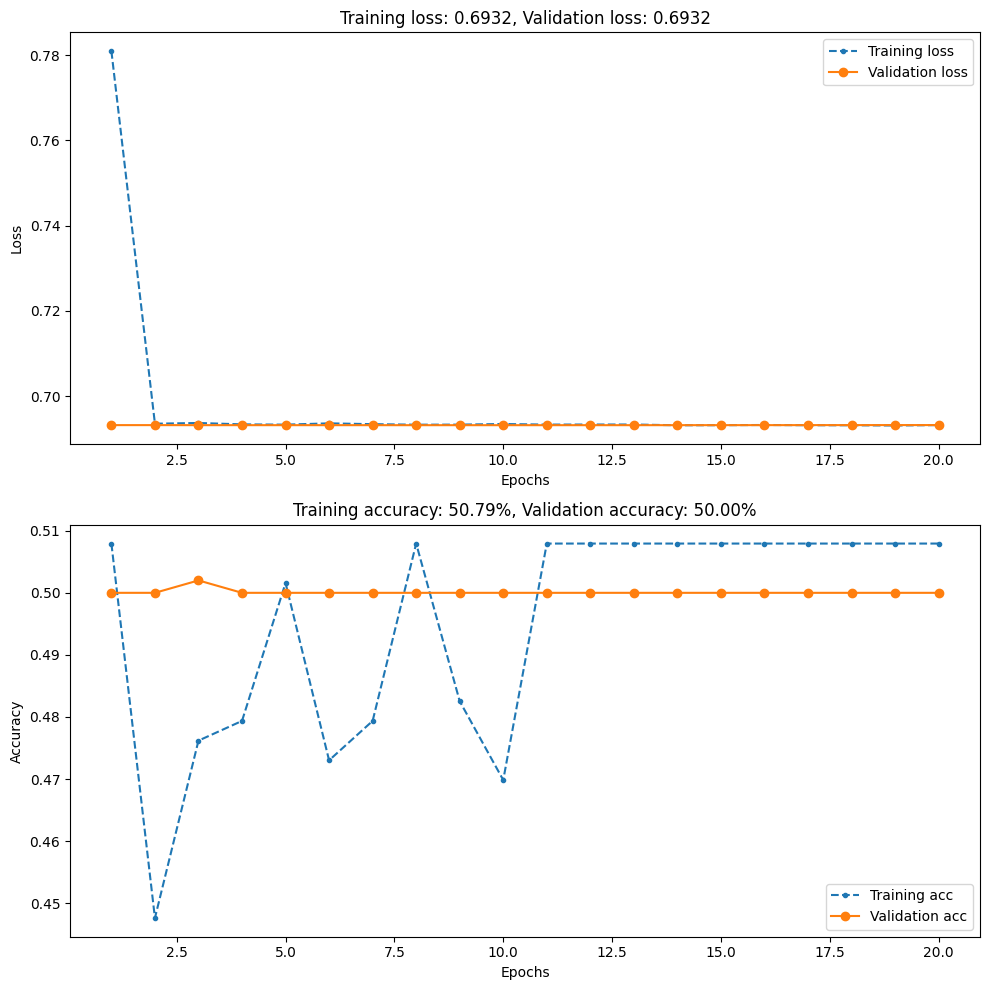

In [76]:
plot_loss_acc(history)

## 5. Finetuning a pretrained model

**(Question)** Load the feature extraction part of VGG16 model. The feature extraction part corresponds to the CNN part, without the MLP classifier at the end.

In [66]:
# Using previous and existing models combined with custom layers for custom classification
from tensorflow.keras.applications import VGG16

# using VGG16 CNN
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Stopping at block5_pool to flatten and customize the FC phase
feature_extraction = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

**(Question)** Add a custom MLP classifier on top of the VGG16 feature extraction part.

In [77]:
# Customized FC Block
mlp_clf = Sequential([
    Flatten(input_shape=feature_extraction.output_shape[1:]),

    Dense(32, activation='relu', kernel_initializer=GlorotNormal),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_initializer=GlorotNormal),
    Dropout(0.5),
    Dense(2, activation='sigmoid', kernel_initializer=GlorotNormal)
])

# Combining models
vgg_model = Sequential([
    feature_extraction,
    mlp_clf
])

vgg_model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 4, 4, 512)         14714688  
                                                                 
 sequential_31 (Sequential)  (None, 2)                 263298    
                                                                 
Total params: 14977986 (57.14 MB)
Trainable params: 14977986 (57.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**(Question)** Compile and train your model. You should be able to reach a validation accuracy >87%. Analyze your results and compare with your initial model trained from scratch.

In [78]:
vgg_model.compile(optimizer=Adam(learning_rate=0.001), loss="BinaryCrossentropy", metrics=["accuracy", tf.keras.metrics.Recall()])
history = vgg_model.fit(augmented_dataset, epochs=20, validation_data=valid_dataset, batch_size=32)

Epoch 1/20
63/63 [==============================] - 12s 75ms/step - loss: 0.7415 - accuracy: 0.4540 - recall_21: 0.4381 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_recall_21: 1.0000
Epoch 2/20
63/63 [==============================] - 5s 81ms/step - loss: 0.6934 - accuracy: 0.4571 - recall_21: 0.6603 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_recall_21: 0.5000
Epoch 3/20
63/63 [==============================] - 5s 82ms/step - loss: 0.6933 - accuracy: 0.4889 - recall_21: 0.5365 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_recall_21: 0.5000
Epoch 4/20
63/63 [==============================] - 5s 81ms/step - loss: 0.6933 - accuracy: 0.5079 - recall_21: 0.5175 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_recall_21: 0.5000
Epoch 5/20
63/63 [==============================] - 5s 80ms/step - loss: 0.6932 - accuracy: 0.5079 - recall_21: 0.5079 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_recall_21: 0.5000
Epoch 6/20
63/63 [==============================] - 4s 71ms/step - loss: 0

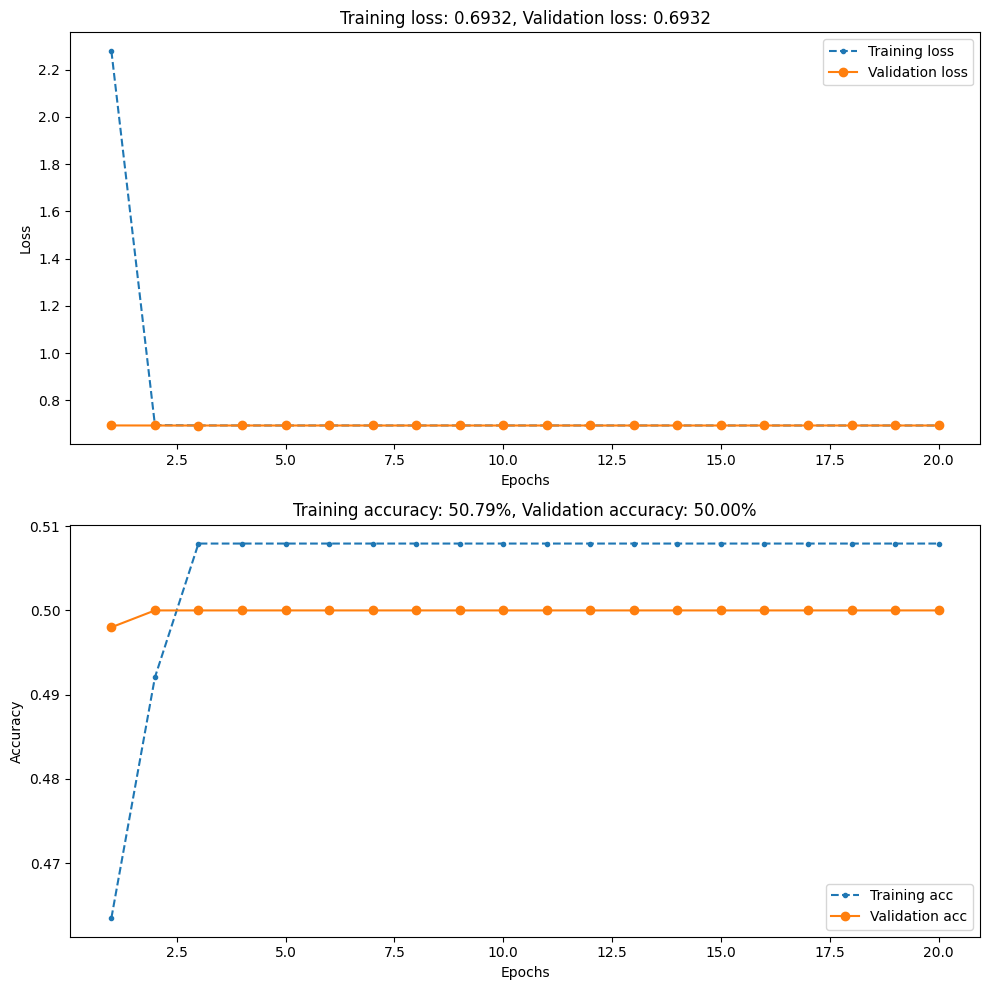

In [69]:
plot_loss_acc(history)

# It's really hard to comment on unexpected results and gain insights from doubtful graphs, but we did some research and we got :

## Answer :
The early layers of a CNN capture low-level features like edges, textures, and simple patterns. These features might be relevant for a wide range of tasks, including binary classification. Depending on the complexity of our classification, the features learned by the pre-trained model may or may not be sufficient. in this case the VGG16 feature extractor should be better than our from scratch model. it's a hybrid approach that helps us use pre-trained models and finetune them for our purposes.